In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder

In [63]:
# Load the dataset
df = pd.read_csv(r'C:/Users/USER/Downloads/Groceries_dataset.csv/Groceries_dataset.csv')

In [64]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.head())

print("\nDataset Information:")
print(df.info())

Dataset Overview:
   Member_number       Date   itemDescription
0           2421 2015-11-21  abrasive cleaner
1           3390 2015-02-21  abrasive cleaner
2           2730 2015-06-15  abrasive cleaner
3           4808 2015-07-26  abrasive cleaner
4           4328 2015-02-04  abrasive cleaner

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB
None


Let's do some Exploratory Data Analysis (EDA) and find out:
- How do the Number of transactions in the year 2015 compare to 2014?
- What are the most popular items purchased?

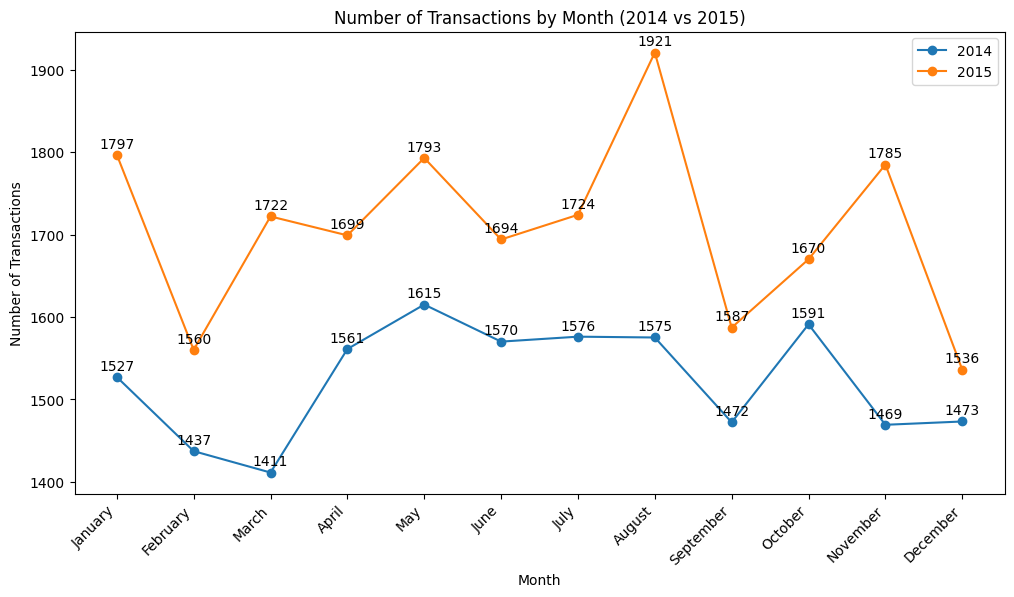

In [65]:
# Visualization 1: Number of transactions per month over the 2 years
# Assuming 'Date' column is in datetime format
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Filter data for each year
df_2014 = df[df['Year'] == 2014]
df_2015 = df[df['Year'] == 2015]

# Group by month and count transactions for each year
transactions_2014 = df_2014.groupby('Month').size()
transactions_2015 = df_2015.groupby('Month').size()

# Create a line chart
plt.figure(figsize=(12, 6))

plt.plot(transactions_2014.index, transactions_2014.values, label='2014', marker='o')
plt.plot(transactions_2015.index, transactions_2015.values, label='2015', marker='o')

# Add labels for each data point
for i, txt in enumerate(transactions_2014.values):
    plt.annotate(txt, (transactions_2014.index[i], txt), textcoords="offset points", xytext=(0,5), ha='center')

for i, txt in enumerate(transactions_2015.values):
    plt.annotate(txt, (transactions_2015.index[i], txt), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('Number of Transactions by Month (2014 vs 2015)')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(range(1, 13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=45, ha='right')
plt.legend()

plt.show()


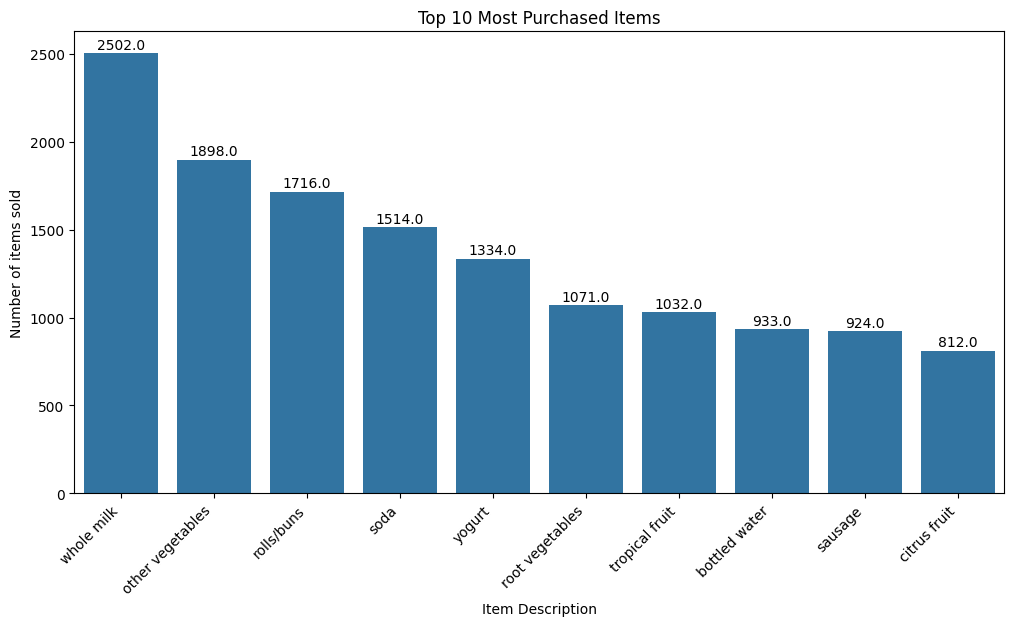

In [66]:
# Visualization 2: The Most Purchased items
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='itemDescription', data=df, order=df['itemDescription'].value_counts().index[:10])

# Add labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 6), textcoords='offset points')

plt.title('Top 10 Most Purchased Items')
plt.xlabel('Item Description')
plt.ylabel('Number of items sold')
plt.xticks(rotation=45, ha='right')
plt.show()



Now that we have explored some of our data, we need to focus on the main problem we want to solve. 
1. Which products are often bought together?
2. What are the possible product bundling options?

To answer this we need to conduct a Market Basket Analysis (MBA)

In [67]:
# Market Basket Analysis using FP-Growth
# Convert the dataset into a transaction format
transactions = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index(name='items')

# Transform the data into a one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transactions['items']).transform(transactions['items'])
sparse_df = pd.DataFrame(te_ary, columns=te.columns_)

In [68]:

# Run FP-Growth algorithm
frequent_itemsets = fpgrowth(sparse_df, min_support=0.001, use_colnames=True)


# Display the frequent itemsets
print("\nFrequent Itemsets:")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))




Frequent Itemsets:
     support            itemsets
0   0.157923        (whole milk)
17  0.122101  (other vegetables)
11  0.110005        (rolls/buns)
6   0.097106              (soda)
3   0.085879            (yogurt)
26  0.069572   (root vegetables)
20  0.067767    (tropical fruit)
38  0.060683     (bottled water)
4   0.060349           (sausage)
62  0.053131      (citrus fruit)


In [69]:
# Generate association rules
from mlxtend.frequent_patterns import association_rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.001)

# Display the association rules
print("\nAssociation Rules:")
print(rules.sort_values(by='confidence', ascending=False).head(10))


Association Rules:
                antecedents   consequents  antecedent support  \
76        (yogurt, sausage)  (whole milk)            0.005748   
82    (rolls/buns, sausage)  (whole milk)            0.005347   
88          (soda, sausage)  (whole milk)            0.005948   
93    (semi-finished bread)  (whole milk)            0.009490   
54     (yogurt, rolls/buns)  (whole milk)            0.007819   
75    (whole milk, sausage)      (yogurt)            0.008955   
497             (detergent)  (whole milk)            0.008621   
1153                  (ham)  (whole milk)            0.017109   
639          (bottled beer)  (whole milk)            0.045312   
553           (frozen fish)  (whole milk)            0.006817   

      consequent support   support  confidence      lift  leverage  \
76              0.157923  0.001470    0.255814  1.619866  0.000563   
82              0.157923  0.001136    0.212500  1.345594  0.000292   
88              0.157923  0.001069    0.179775  1.1383

In [70]:
# Identify all combinations
all_combinations = rules.sort_values(by='support', ascending=False)

# Deduplicate based on the sorted frozensets of antecedents and consequents
all_combinations['sorted_antecedents'] = all_combinations['antecedents'].apply(lambda x: frozenset(sorted(x)))
all_combinations['sorted_consequents'] = all_combinations['consequents'].apply(lambda x: frozenset(sorted(x)))

# Function to check if two combinations are the same regardless of order
def are_combinations_equal(comb1, comb2):
    return (comb1['sorted_antecedents'] == comb2['sorted_consequents']) and (comb1['sorted_consequents'] == comb2['sorted_antecedents'])

# Deduplicate using the function
unique_combinations_all = [all_combinations.iloc[0].copy()]

for i in range(1, len(all_combinations)):
    current_comb = all_combinations.iloc[i].copy()  # Making a copy to avoid SettingWithCopyWarning
    is_duplicate = False

    for unique_comb in unique_combinations_all:
        if are_combinations_equal(current_comb, unique_comb):
            is_duplicate = True
            unique_comb['support'] += current_comb['support']  # Adding up the support
            unique_comb['confidence'] = max(unique_comb['confidence'], current_comb['confidence'])  # Keep the higher confidence

    if not is_duplicate:
        unique_combinations_all.append(current_comb)

# Create a new column for simplified labels
for combo in unique_combinations_all:
    combo['combined_labels'] = ', '.join(map(str, combo['antecedents'] | combo['consequents']))

# Display the first 20 unique combinations
unique_combinations_all_df = pd.DataFrame(unique_combinations_all)
print("\nTop Unique Combinations")
print(unique_combinations_all_df[['combined_labels', 'support', 'confidence']].head(20))



Top Unique Combinations
                      combined_labels   support  confidence
353      whole milk, other vegetables  0.029673    0.121511
171            whole milk, rolls/buns  0.027936    0.126974
97                   whole milk, soda  0.023257    0.119752
38                 whole milk, yogurt  0.022322    0.129961
173      rolls/buns, other vegetables  0.021119    0.095990
98             soda, other vegetables  0.019381    0.099794
59                whole milk, sausage  0.017911    0.148394
422        whole milk, tropical fruit  0.016441    0.121302
101                  soda, rolls/buns  0.016173    0.083276
42           yogurt, other vegetables  0.016173    0.094163
45                 yogurt, rolls/buns  0.015639    0.091051
485       whole milk, root vegetables  0.015104    0.108549
896          whole milk, citrus fruit  0.014302    0.134591
632         whole milk, bottled water  0.014302    0.117841
638          whole milk, bottled beer  0.014302    0.157817
500            

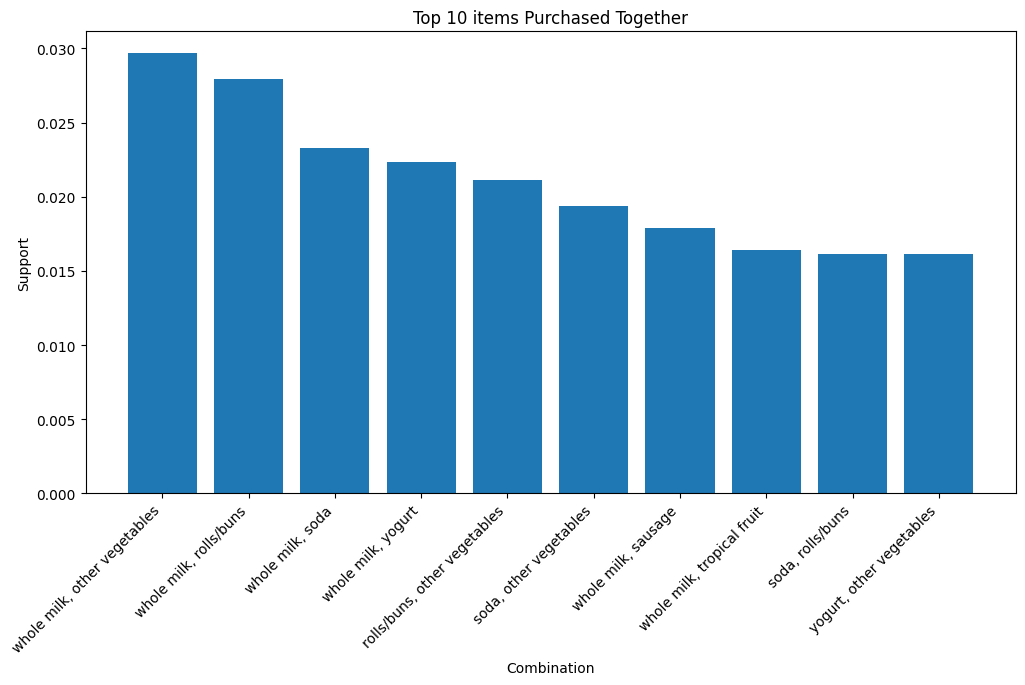

In [71]:
# Visualize the top 10 unique combinations
plt.figure(figsize=(12, 6))
top_combinations_all_df = unique_combinations_all_df.head(10)
plt.bar(range(len(top_combinations_all_df)), top_combinations_all_df['support'], tick_label=top_combinations_all_df['combined_labels'])
plt.title('Top 10 items Purchased Together')
plt.xlabel('Combination')
plt.ylabel('Support')
plt.xticks(rotation=45, ha='right')
plt.show()


The above bar chart tells us the top 10 combinations of products often bought together. However, we notice that "whole milk" appears 6 times with other products, additionally when I checked for first 20 unique combinations, whole milk appeared 13 times. It is also the most bought item, therefore, it seems people will buy whole milk even if it is bundled with other products or not. 

So we need to check the most popular combinations that do not include whole milk so we can learn what products to bundle together for promotions!

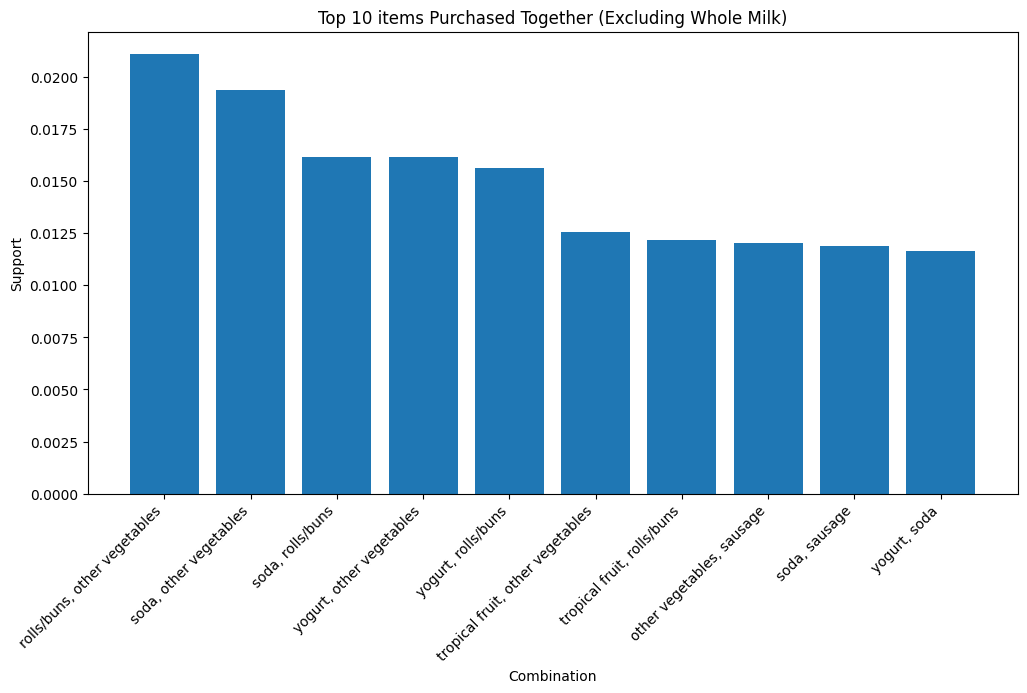

In [72]:
# Visualize the top 10 unique combinations excluding 'whole milk'
plt.figure(figsize=(12, 6))
filtered_combinations_all_df = unique_combinations_all_df[~unique_combinations_all_df['combined_labels'].apply(lambda x: 'whole milk' in x)]
top_filtered_combinations_all_df = filtered_combinations_all_df.head(10)

plt.bar(range(len(top_filtered_combinations_all_df)), top_filtered_combinations_all_df['support'], tick_label=top_filtered_combinations_all_df['combined_labels'])
plt.title('Top 10 items Purchased Together (Excluding Whole Milk)')
plt.xlabel('Combination')
plt.ylabel('Support')
plt.xticks(rotation=45, ha='right')
plt.show()


Now we have a more accurate combination of products that we can bundle together. 'other vegetables', 'rolls/buns' and 'soda' seem to be very popular amongst all combinations and from our previous observations about whole milk, we can have the following promotions!

- Get a whole milk at a discounted price or free when the customer's bill crosses a certain amount.

  (**_Note:_**    _I would look into what the average transaction bill is and set that as a threshold_)


- Bundle other vegetables, soda, rolls/buns and sell them at a discounted price.
- Bundle other vegetables and yoghurt as a promotion.
- Bundle yoghurt and rolls/buns as a promotion.

SInce the support for other combinations is less than 0.0150, I would recommend the above combinations only as they appear more often!